# HW 3: Getting Comfortable with Feature Engineering
**OPIM 5512: Big Data Analytics with Cloud Computing - University of Connecticut**

* Your Name Here: PJ Watson
* Your StudentID Here: 2887247

It's time to get some practice with the different options for feature engineering in PySpark!

Check out these resources:
* https://spark.apache.org/docs/1.4.0/ml-features.html
* https://dhiraj-p-rai.medium.com/essentials-of-feature-engineering-in-pyspark-part-i-76a57680a85 ($$ to access)
* https://www.kaggle.com/code/dhirajrai87/feature-engineering-with-pyspark
* https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer
  * I personally have never used the normalizer, but I am curious how well it would do as feature engineering tool when we start fitting models - students, please do some reading on this and see if/when it's useful for feature engineering! Sample-based (row) feature engineering vs. feature-based (column) approaches.

And you will notice that the common things you can do in PySpark are:
* Feature Transformers
* PolynomialExpansion*
* StringIndexer
* OneHotEncoder
* VectorIndexer
* Normalizer*
* StandardScaler* (do this one last!)
* Bucketizer*
* ElementwiseProduct
* VectorAssembler
  * You PROBABLY need to run this one first, so I will do it for you to start.

# Rubric
Using the CA Housing Dataset on the right, please try these FOUR methods (PolynomialExpansion, Bucketizer, Normalizer and StandardScaler). I want one subheader per method with a description of what you did, the code to apply the method (which runs successfully on train and is correctly applied to test), and for you to check your work with printing a few rows and/or checking shape.

You should be adding one more column each time you do a method! Give each new column a nice name that corresponds to the method (like 'columns_scaled').

I give the `VectorAssembler` and some data reading code for you to get started.

20 points per method (80 points) and 20 points for five meaningful bullets on what you learned.

**Note:** if you are referencing other useful materials online, please feel free to share them on the Discussion Board!

# Start PySpark and Read Data from Colab

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=fc4de700feb2a73a8b6e778815eced05f4a9da892e1b0b3fe416e1ae488657c1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder\
        .appName("FeatureEngineering_HW")\
        .getOrCreate()

In [3]:
# specify the directory
DIRECTORY = '/content/sample_data'

In [4]:
import os

# read the train data
train = spark.read.csv(
 path=os.path.join(DIRECTORY, "california_housing_train.csv"),
 sep=",",
 header=True,
 inferSchema=True,
 timestampFormat="yyyy-MM-dd", # used to tell spark the format of dateTime columns
)

# read the test data
test = spark.read.csv(
 path=os.path.join(DIRECTORY, "california_housing_test.csv"),
 sep=",",
 header=True,
 inferSchema=True,
 timestampFormat="yyyy-MM-dd", # used to tell spark the format of dateTime columns
)

In [5]:
# view first few rows
# does this data look right?
# not initially, but total_rooms, total_bedrooms, population etc are values within a *BLOCK*
#
# https://developers.google.com/machine-learning/crash-course/california-housing-data-description
print('This is train:')
print(train.count(), len(train.columns))
train.show(10)
print('This is test:')
print(test.count(), len(test.columns))
test.show(10)

This is train:
17000 9
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|        1.925|           65500.0|
|

In [6]:
# check data quality
# any missing values?
# https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/

print('This is train:')
train.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in train.columns]).show()
print('This is test:')
test.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in test.columns]).show()

This is train:
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+

This is test:
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------------

# (Dave's demo) VectorAssembler
This method will combine all of the columns of interest into a single vector column. This vector column has been optimized for ML pipelines. You can think of it as each row having a list with ALL of the columns of interest inside of it.

(see also DD's chap12 notebook)

## Train

In [7]:
train.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [8]:
# these are the cols with continuous data vs binary
CONTINUOUS_COLUMNS = ['longitude',
                      'latitude',
                      'housing_median_age',
                      'total_rooms',
                      'total_bedrooms',
                      'population',
                      'households',
                      'median_income'] # note that we dropped the target variable here!
print(CONTINUOUS_COLUMNS)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [9]:
TARGET_COLUMN = ['median_house_value']
print(TARGET_COLUMN)

['median_house_value']


In [10]:
from pyspark.ml.feature import VectorAssembler

# we input all the continuous columns as a vector "CONTINUOUS_COLUMNS"
continuous_features = VectorAssembler(inputCols=CONTINUOUS_COLUMNS, outputCol="continuous_features")

In [11]:
#remove all the vector data with null values
for x in CONTINUOUS_COLUMNS:

# refresh CONTINUOUS_COLUMNS
# CONTINUOUS_COLUMNS = ['longitude',
#                      'latitude',
#                      'housing_median_age',
#                     'total_rooms',
#                      'total_bedrooms',
#                      'population',
#                     'households',
#                     'median_income'

  vector_df_train = train.where(~F.isnull(F.col(x)))
  vector_df_test = test.where(~F.isnull(F.col(x)))

In [12]:
# refresh vector_df_train, vector_df_test
print('This is vector_df_train after is not null:')
print(vector_df_train.count(), len(vector_df_train.columns))
vector_df_train.show(10)
print('This is vector_df_test after is not null:')
print(vector_df_test.count(), len(vector_df_test.columns))
vector_df_test.show(10)
# row, col count is the same as train, test read in initially, no nulls dropped

This is vector_df_train after is not null:
17000 9
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|       

In [13]:
#transform, scroll rt
vector_variable_train = continuous_features.transform(vector_df_train)
print('This is vector_variable_train:')
print(vector_variable_train.count(), len(vector_variable_train.columns))
vector_variable_train.show() # see how all of the features are now in one column?
# 1 col added, vector col continuous_features

This is vector_variable_train:
17000 10
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value| continuous_features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|[-114.31,34.19,15...|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|[-114.47,34.4,19....|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|[-114.56,33.69,17...|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|

## Test

In [14]:
# now apply to test, scroll rt
vector_variable_test = continuous_features.transform(vector_df_test)
print('This is vector_variable_test:')
print(vector_variable_test.count(), len(vector_variable_train.columns))
vector_variable_test.show() # see how all of the features are now in one column?
# 1 col added, vector continuous_features

This is vector_variable_test:
3000 10
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value| continuous_features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|[-122.05,37.37,27...|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|[-118.3,34.26,43....|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|[-117.81,33.78,27...|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|  

# Polynomial Expansion

💚 Background

Polynomial expansion is the process of expanding features into a polynomial space, which is formulated by an n-degree combination of original dimensions. In mathematics, an expansion of a product of sums expresses it as a sum of products by using the fact that multiplication distributes over addition. Take a 2-variable feature vector as an example: (x, y), if we want to expand it with degree 2, then we get (x, x * x, y, x * y, y * y).

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PolynomialExpansion.html

Polynomial expansion is used to generate interaction variables of all the input columns. With polynomial expansion, we specify to what degree we would like to see various interactions. For example, for a degree-2 polynomial, Spark takes every value in our feature vector, multiplies it by every other value in the feature vector, and then stores the results as features. For instance, if we have two input features, we’ll get four output features if we use a second degree polynomial (2x2). If we have three input features, we’ll get nine output features (3x3). If we use a thirddegree polynomial, we’ll get 27 output features (3x3x3) and so on.

This transformation is useful when you want to see interactions between particular features but aren’t necessarily sure about which interactions to consider.

https://www.kaggle.com/code/dhirajrai87/feature-engineering-with-pyspark

💚

Ask DD: what I'm not understanding is performing PolyExp in *1 feature vs between *n features, if this transformation is useful when you want to see interactions between features.

Discuss the need for the input col dtype to be struct (not double). Note code below using VectorAssembly on median_house_value before running PolyExp; also used a UDF to vectorize median_house_value before PolyExp.

💚
Approach

Normally, I'd overwrite a tmp_df to minimize the number of df's generated, but for this exercise, I've opted for distinct df's specific to the process being explored for clarity.

1. vectorize median_house_value

2. decide which degree for PolyExp is desired (on one feature)

3. apply Polynomial Expansion

4. inspect df


Don't confuse Polynomial Features with Polynomial Expansion:
Polynomial features involve taking an existing feature and raising it to a power. This is useful for capturing non-linear relationships between the feature and the target variable. For example, if you have a feature X, polynomial features could include X’2,X’2, X’3,X’3, etc.

Example:
If you have a feature AA, polynomial features could look like:

A’2,A’2 (Square of AA)
A’3,A’3 (Cube of AA)
A(Square root of AA)

Polynomial features involve a single original feature. Polynomial features are useful when the relationship between the feature and the target is non-linear.

https://medium.com/@jonesntongana345/understanding-interaction-and-polynomial-features-in-pyspark-a-simple-guide-ef11f2e80eab


In [15]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.linalg import Vectors

## Train

In [16]:
# temp polynomial expansion df for train df
tmp_poly_train = train
print('This is tmp_poly_train:')
print(tmp_poly_train.count(), len(tmp_poly_train.columns))
tmp_poly_train.printSchema()

This is tmp_poly_train:
17000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [17]:
# watch dtype of feature being input into PolynomialExpansion -
# median_house_value as a double throws errors,
# expecting input col to be struct:
#   IllegalArgumentException: requirement failed:
#   Input type must be struct<type:tinyint,size:int,indices:array<int>,
#   values:array<double>> but got double.
# is there another way to do this without creating a vector col for
# median_house_value?

# Vector Assembler only takes Vector and Float columns, not Array columns

# redundant import; added for documentation
from pyspark.ml.feature import VectorAssembler

# create var for degree, to see what oputput is
# when change degree from 2 to 3

degree = 2

# vectorize median_house_value
assembler = VectorAssembler(inputCols=["median_house_value"], outputCol="median_house_value_vector")
tmp_poly_train = assembler.transform(tmp_poly_train)

# apply PolynomialExpansion
polyExp_train = PolynomialExpansion(degree=degree, inputCol="median_house_value_vector", outputCol="poly_features")
polyExp_train_df = polyExp_train.transform(tmp_poly_train)

print('This is polyExp_train_df:')
print(polyExp_train_df.count(), len(polyExp_train_df.columns))
polyExp_train_df.printSchema()

polyExp_train_df.show(truncate=False)
# the median_house_value_vector as well as poly_features columns were added to df
# when degree = 2, poly_features has two results:
# median_house_value and (median_house_value squared)
# when degree = 3, poly_features has 3 results:
# median_house_value, (median_house_value squared), (median_house_value to 3rd power)

This is polyExp_train_df:
17000 11
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- median_house_value_vector: vector (nullable = true)
 |-- poly_features: vector (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+-------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_vector|poly_features      |
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-

## Test

In [18]:
# temp polynomial expansion df for test df
tmp_poly_test = test
print('This is tmp_poly_test:')
print(tmp_poly_test.count(), len(tmp_poly_test.columns))
tmp_poly_test.printSchema()

This is tmp_poly_test:
3000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [19]:
# polynomial expansion on train df
degree = 2

# vectorize median_house_value
assembler = VectorAssembler(inputCols=["median_house_value"], outputCol="median_house_value_vector")
tmp_poly_test = assembler.transform(tmp_poly_test)

# apply PolynomialExpansion
polyExp_test = PolynomialExpansion(degree=degree, inputCol="median_house_value_vector", outputCol="poly_features")
polyExp_test_df = polyExp_test.transform(tmp_poly_test)

print('This is polyExp_test_df:')
print(polyExp_test_df.count(), len(polyExp_test_df.columns))
polyExp_test_df.printSchema()

polyExp_test_df.show(truncate=False)

This is polyExp_test_df:
3000 11
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- median_house_value_vector: vector (nullable = true)
 |-- poly_features: vector (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_vector|poly_features          |
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------------

## Polynomial Expansion: playing with UDF to change median_house_value from double to vector


In [20]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
tmp_poly_test_with_vectors = tmp_poly_test.select(
    tmp_poly_test["median_house_value"],
    list_to_vector_udf(tmp_poly_test["median_house_value"]).alias("median_house_value_vector")
)
print('This is tmp_poly_test_with_vectors:')
print(tmp_poly_test_with_vectors.count(), len(tmp_poly_test_with_vectors.columns))
tmp_poly_test_with_vectors.printSchema()
tmp_poly_test_with_vectors.show(truncate=False)

This is tmp_poly_test_with_vectors:
3000 2
root
 |-- median_house_value: double (nullable = true)
 |-- median_house_value_vector: vector (nullable = true)

+------------------+-------------------------+
|median_house_value|median_house_value_vector|
+------------------+-------------------------+
|344700.0          |[344700.0]               |
|176500.0          |[176500.0]               |
|270500.0          |[270500.0]               |
|330000.0          |[330000.0]               |
|81700.0           |[81700.0]                |
|67000.0           |[67000.0]                |
|67000.0           |[67000.0]                |
|166900.0          |[166900.0]               |
|194400.0          |[194400.0]               |
|164200.0          |[164200.0]               |
|125000.0          |[125000.0]               |
|58300.0           |[58300.0]                |
|252600.0          |[252600.0]               |
|231200.0          |[231200.0]               |
|222500.0          |[222500.0]               

# Bucketizer

💚 Background

Maps a column of continuous features to a column of feature buckets. Since 3.0.0, Bucketizer can map multiple columns at once by setting the inputCols parameter.

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Bucketizer.html

Bucketing is an optimization technique that uses buckets (and bucketing columns) to determine data partitioning and avoid data shuffle in join queries. The motivation is to optimize performance of a join query by avoiding shuffles (exchanges) of tables participating in the join.

It takes a parameter: splits:

Parameter for mapping continuous features into buckets. With n+1 splits, there are n buckets. A bucket defined by splits x,y holds values in the range [x,y) except the last bucket, which also includes y. Splits should be strictly increasing. Values at -inf, inf must be explicitly provided to cover all Double values; Otherwise, values outside the splits specified will be treated as errors. Two examples of splits are Array(Double.NegativeInfinity, 0.0, 1.0, Double.PositiveInfinity) and Array(0.0, 1.0, 2.0).

Note that if you have no idea of the upper and lower bounds of the targeted column, you should add Double.NegativeInfinity and Double.PositiveInfinity as the bounds of your splits to prevent a potential out of Bucketizer bounds exception.

Why is Bucketing important?
Performance Improvement: Bucketing can significantly improve the performance of Spark jobs that involve shuffle operations like groupBy, join, orderBy, etc., by limiting the number of outputs and reducing the data shuffle across the network.
Avoid Data Skew: Bucketing can help avoid data skew in certain operations, leading to more efficient utilization of resources.
Reduce Data Redundancy: When performing operations on a subset of data, bucketing allows Spark to avoid full data scan, reducing IO operations and improving query performance.

💚 Approach

1. inspect min, max to determine appropriate buckets

2. apply Bucketizer

3. inspect df and distinct bucket counts, compare train and test

## Train


In [21]:
# temp bucketizer df for train df
tmp_bucketizer_train = train
print('This is tmp_bucketizer_train:')
print(tmp_bucketizer_train.count(), len(tmp_bucketizer_train.columns))
tmp_bucketizer_train.printSchema()

This is tmp_bucketizer_train:
17000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [22]:
# explore min, max for train median_house_value

# Note that if you have no idea of the upper and lower bounds
# of the targeted column, you should add
# Double.NegativeInfinity and Double.PositiveInfinity
# as the bounds of your splits to prevent a potential
# out of Bucketizer bounds exception.
tmp_bucketizer_train.select("median_house_value").describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             17000|
|   mean|207300.91235294117|
| stddev|115983.76438720895|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



In [23]:
# Bucketizer tmp_bucketizer_train

from pyspark.ml.feature import Bucketizer

# buckets/splits
splits = [float("-inf"), 100000, 200000, 300000, 400000, 500000, float("inf")]

bucketizer = Bucketizer(splits=splits, inputCol="median_house_value", outputCol="median_house_value_bucket")

# apply Bucketizer
bucketed_train_df = bucketizer.transform(tmp_bucketizer_train)

# inspect
bucketed_train_df.show(50)

# inspect distinct values
distinct_bucket_values = bucketed_train_df.groupBy("median_house_value_bucket").count()
distinct_bucket_values.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_bucket|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|                      0.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|                      0.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|                      0.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|          

## Test

In [24]:
# temp bucketizer df for test df
tmp_bucketizer_test = test
print('This is tmp_bucketizer_test:')
print(tmp_bucketizer_test.count(), len(tmp_bucketizer_test.columns))
tmp_bucketizer_test.printSchema()

This is tmp_bucketizer_test:
3000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [25]:
# explore min, max for test median_house_value

tmp_bucketizer_test.select("median_house_value").describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|              3000|
|   mean|        205846.275|
| stddev|113119.68746964622|
|    min|           22500.0|
|    max|          500001.0|
+-------+------------------+



In [26]:
# Bucketizer tmp_bucketizer_test

# same buckets/splits
splits = [float("-inf"), 100000, 200000, 300000, 400000, 500000, float("inf")]

bucketizer = Bucketizer(splits=splits, inputCol="median_house_value", outputCol="median_house_value_bucket")

# apply Bucketizer
bucketed_test_df = bucketizer.transform(tmp_bucketizer_test)

# inspect
bucketed_test_df.show(50)

# inspect distinct values
distinct_bucket_values = bucketed_test_df.groupBy("median_house_value_bucket").count()
distinct_bucket_values.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_bucket|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|                      3.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|                      1.0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|                      2.0|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|          

# Normalizer

💚 Background

The purpose of normalization is to scale features (vectors) so that they have a consistent magnitude or length. It ensures that each feature contributes equally to the overall distance or similarity calculations.
Normalization is particularly useful when dealing with algorithms that are sensitive to the scale of features, such as distance-based methods (e.g., k-means clustering, k-nearest neighbors).

When parm p=2 in the Normalizer transformer, it will normalize each vector to have a unit L squared norm, meaning that the Euclidean norm of each vector will be equal to 1 after normalization.

This normalization technique is often used in machine learning to scale feature vectors to have unit length, which can be useful for certain algorithms or when measuring similarity based on the direction of vectors rather than their magnitude.

💚 Approach

1. vectorize median_house_value

2. apply Normalizer with p=2 for L2 norm

3. inspect df, distinct counts, compare train and test

4. needs research: all rows were normalized to 1 for train and test

After reading https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer, I can see why the values for feature median_house_value are all 1. After applying any type of Normalizer, the data set {1,2,3,4,5} becomes {1.,1.,1.,1.,1.} since the only feature is divided by itself. So Normalizer has no use for this case. Normalizer is not used as a pre-processing step; although, it might be used as an ad-hoc feature engineering step similar to what a neuron does in a neural network. Normalizer is mostly useful for controlling the size of a vector in an iterative process, e.g. a parameter vector during training, to avoid numerical instabilities due to large values.

Normalizer normalizes ROWS (samplewise), not columns (featurewise). It totally changes the meaning of data because the distributions of resulting feature values are totally changed. Therefore, a scenario where it can be useful is when you consider a feature to be the relation between feature values samplewise rather than featurewise.

Use StandardScaler if you want each feature to have zero-mean, unit standard-deviation. If you want more normally distributed data, and are okay with transforming your data. Check out scikit-learn’s QuantileTransformer(output_distribution='normal').
Use MinMaxScaler if you want to have a light touch. It’s non-distorting.
You could use RobustScaler if you have outliers and want to reduce their influence.
Use Normalizer sparingly — it normalizes sample rows, not feature columns. It can use l2 or l1 normalization.
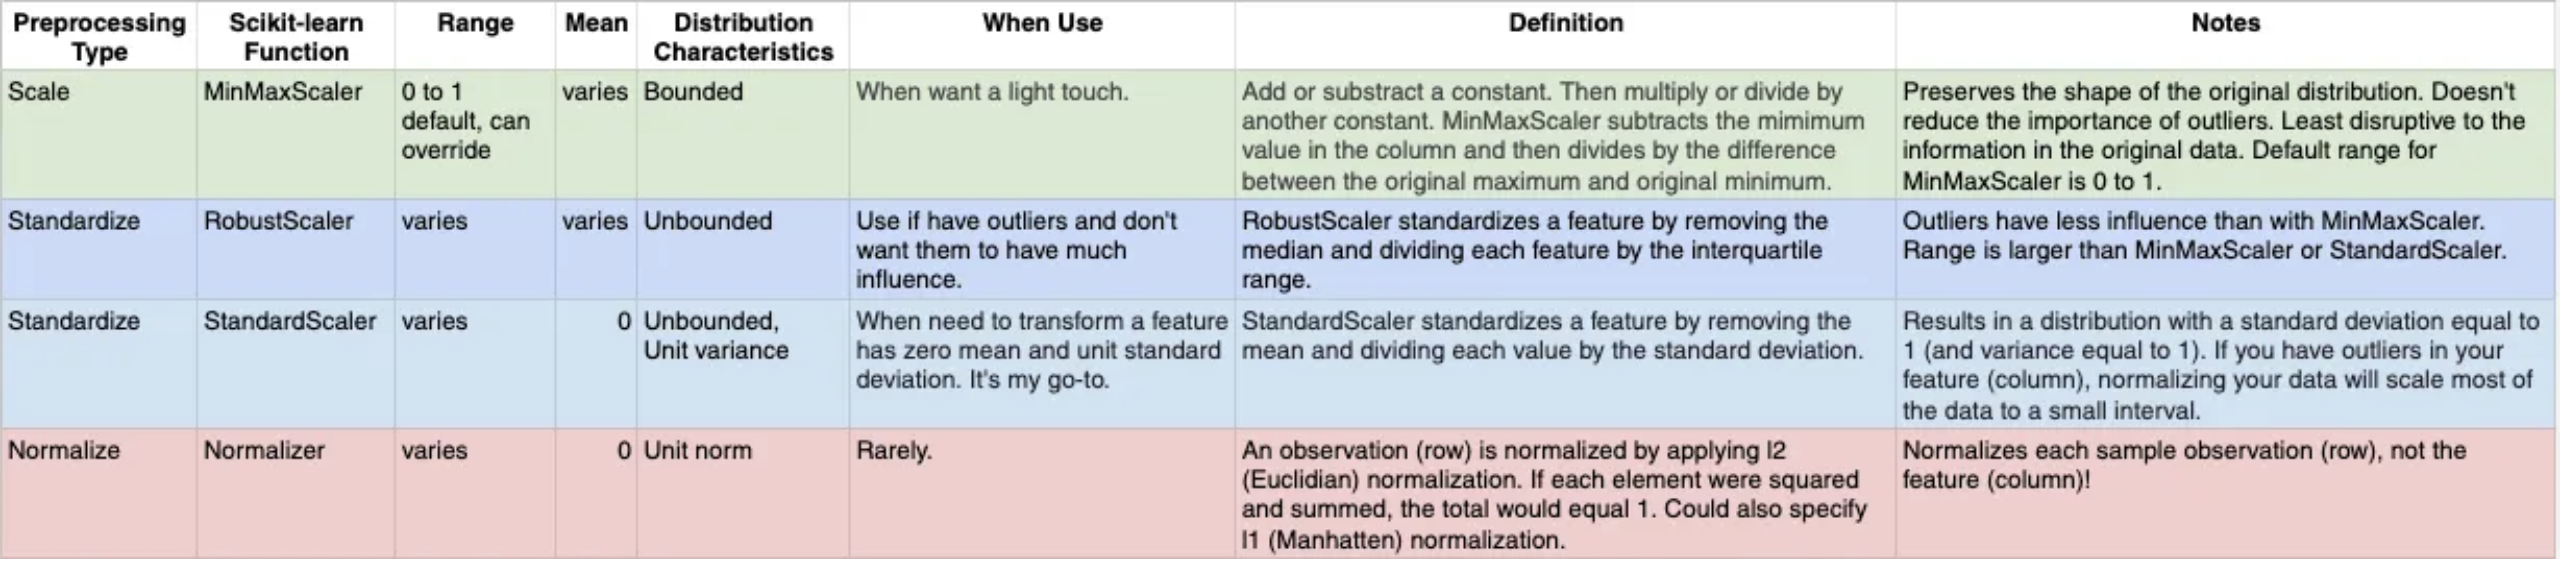
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02



## Train

In [27]:
# temp Normalizer df for train df
tmp_normalizer_train = train
print('This is tmp_normalizer_train:')
print(tmp_normalizer_train.count(), len(tmp_normalizer_train.columns))
tmp_normalizer_train.printSchema()


This is tmp_normalizer_train:
17000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [28]:
# Normalizer tmp_normalizer_train

from pyspark.ml.feature import Normalizer

# parm  p float
# normalization in L^p^ space, p = 2 by default.

# Trials and tribulations w input dtype...
# Normalizer transformer expects input columns to be vectors,
# not scalar values.


# vectorize median_house_value
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["median_house_value"], outputCol="median_house_value_vector")
tmp_normalizer_train = assembler.transform(tmp_normalizer_train)

normalizer = Normalizer(inputCol="median_house_value_vector", outputCol="median_house_value_norm", p=2.0)

normalized_train_df = normalizer.transform(tmp_normalizer_train)

# inspect
normalized_train_df.show(50)

# inspect distinct values
distinct_bucket_values = normalized_train_df.groupBy("median_house_value_norm").count()
distinct_bucket_values.show()
# all median_house_value rows have been normalized to 1
# correct? resolve

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_vector|median_house_value_norm|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+-----------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|                [66900.0]|                  [1.0]|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|                [80100.0]|                  [1.0]|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|                [85

In [29]:
# repeat with p = 1 (L1); does it make a difference??
# Normalizer tmp_normalizer_train

from pyspark.ml.feature import Normalizer

# parm  p float
# normalization in L^p^ space, p = 2 by default.

# Trials and tribulations w input dtype...
# Normalizer transformer expects input columns to be vectors,
# not scalar values.


# vectorize median_house_value
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["median_house_value"], outputCol="median_house_value_vector_L1")
tmp_normalizer_train = assembler.transform(tmp_normalizer_train)

normalizer = Normalizer(inputCol="median_house_value_vector_L1", outputCol="median_house_value_norm", p=1.0)

normalized_train_df = normalizer.transform(tmp_normalizer_train)

# inspect
normalized_train_df.show(50)

# inspect distinct values
distinct_bucket_values = normalized_train_df.groupBy("median_house_value_norm").count()
distinct_bucket_values.show()
# all median_house_value rows have been normalized to 1, juist like above p=2 (L2)
# correct? resolve

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+----------------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_vector|median_house_value_vector_L1|median_house_value_norm|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+----------------------------+-----------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|                [66900.0]|                   [66900.0]|                  [1.0]|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|                [80100.0]|                   [80100.0]|                  [1

## Test

In [30]:
# temp Normalizer df for test df
tmp_normalizer_test = test
print('This is tmp_normalizer_test:')
print(tmp_normalizer_test.count(), len(tmp_normalizer_test.columns))
tmp_normalizer_test.printSchema()

This is tmp_normalizer_test:
3000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [31]:
# Normalizer tmp_normalizer_test


# parm  p float
# normalization in L^p^ space, p = 2 by default.

# vectorize median_house_value
assembler = VectorAssembler(inputCols=["median_house_value"], outputCol="median_house_value_vector")
tmp_normalizer_test = assembler.transform(tmp_normalizer_test)

normalizer = Normalizer(inputCol="median_house_value_vector", outputCol="median_house_value_norm", p=2.0)

normalized_train_df = normalizer.transform(tmp_normalizer_test)

# inspect
normalized_train_df.show(50)

# inspect distinct values
distinct_bucket_values = normalized_train_df.groupBy("median_house_value_norm").count()
distinct_bucket_values.show()
# all median_house_value rows have been normalized to 1
# correct? resolve

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_vector|median_house_value_norm|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+-----------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|               [344700.0]|                  [1.0]|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|               [176500.0]|                  [1.0]|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|               [270

# StandardScaler

💚 Background

StandardScaler is pecifically designed to standardize features by removing the mean and scaling to unit variance.

Purpose:

Improved Model Performance: Many machine learning algorithms, especially those sensitive to feature scales, benefit from standardized data. StandardScaler ensures that no single feature dominates the model fitting process solely due to its scale.
Balanced Feature Contribution: By centering features around zero (mean removal) and scaling them to have a unit standard deviation, StandardScaler creates a more balanced playing field for all features, allowing the model to learn more effectively from each one.

Functionality:

Mean Removal: For each feature (column) of data, StandardScaler subtracts the mean value of that feature from all its data points. This essentially repositions the data distribution such that the mean for each feature becomes zero.
Unit Variance Scaling: After centering the data, StandardScaler divides each data point in a feature by the standard deviation of that feature. This ensures that the data distribution for each feature has a standard deviation of one.

Benefits:

Enhanced Algorithm Performance: Standardization can lead to faster convergence and potentially better model performance for many machine learning algorithms, especially those based on distance metrics (e.g., k-Nearest Neighbors, Support Vector Machines).
Reduced Sensitivity to Outliers: By scaling features, StandardScaler can mitigate the influence of outliers in your data, which might otherwise skew the model's learning process.
Implementation:

💚

Approach

1. vectorize median_house_value

2. apply StandardScaler  

3. inspect df, distinct counts, compare train and test




## Train


In [32]:
# temp StandardScaler df for train df
tmp_standardscaler_train = train
print('This is tmp_standardscaler_train:')
print(tmp_standardscaler_train.count(), len(tmp_standardscaler_train.columns))
tmp_standardscaler_train.printSchema()

This is tmp_standardscaler_train:
17000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [33]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="median_house_value", outputCol="median_house_value_scaled",
                        withMean=True, withStd=True)
# again, input needs to be vector
# vectorize median_house_value

assembler = VectorAssembler(inputCols=["median_house_value"], outputCol="median_house_value_vector")
tmp_standardscaler_train = assembler.transform(tmp_standardscaler_train)


# StandardScaler
scaler = StandardScaler(inputCol="median_house_value_vector", outputCol="median_house_value_vector_scaled",
                        withMean=True, withStd=True)

# Fit and transform the data
scaler_model = scaler.fit(tmp_standardscaler_train)
scaled_train_df = scaler_model.transform(tmp_standardscaler_train)

# inspect
scaled_train_df.show(50)
# inspect distinct values
distinct_bucket_values = scaled_train_df.groupBy("median_house_value_vector_scaled").count()
distinct_bucket_values.show()
# many nmore distinct StandardScaler values

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+--------------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_vector|median_house_value_vector_scaled|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+--------------------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|                [66900.0]|            [-1.2105221200116...|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|                [80100.0]|             [-1.09671308760323]|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       

## Test

In [34]:
# temp StandardScaler df for test df
tmp_standardscaler_test = test
print('This is tmp_standardscaler_test:')
print(tmp_standardscaler_test.count(), len(tmp_standardscaler_test.columns))
tmp_standardscaler_test.printSchema()

This is tmp_standardscaler_test:
3000 9
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [35]:
# StandardScaler for test
scaler = StandardScaler(inputCol="median_house_value", outputCol="median_house_value_scaled",
                        withMean=True, withStd=True)
# again, input needs to be vector
# vectorize median_house_value

assembler = VectorAssembler(inputCols=["median_house_value"], outputCol="median_house_value_vector")
tmp_standardscaler_test = assembler.transform(tmp_standardscaler_test)


# StandardScaler
scaler = StandardScaler(inputCol="median_house_value_vector", outputCol="median_house_value_vector_scaled",
                        withMean=True, withStd=True)

# Fit and transform the data
scaler_model = scaler.fit(tmp_standardscaler_test)
scaled_test_df = scaler_model.transform(tmp_standardscaler_test)

# inspect
scaled_test_df.show(50)
# inspect distinct values
distinct_bucket_values = scaled_test_df.groupBy("median_house_value_vector_scaled").count()
distinct_bucket_values.show()
# many nmore distinct StandardScaler values

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+--------------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|median_house_value_vector|median_house_value_vector_scaled|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------------+--------------------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|               [344700.0]|            [1.2274938881638957]|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|               [176500.0]|            [-0.2594267687300...|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       

# Bullets
Don't skip this - 20 points on the line! Do a good job here.

💚 Musings

1. After reading chapter 12, and DD's chapter 12 code, I understand that VectorAssembler is useful for combining raw features (and features generated by different feature transformers) into a single feature vector, in order to train ML models like logistic regression and decision trees. But until we get there, I'm not really sure why it's useful.
2. Alot of the coding/recoding in this exercise centered around debugging what type of input (dtype) was required for the function being coded. Some functions needed VectorAssembler to be run to "vectorize" the input feature before running the feature.
3. Not clear when to use Normalize, and I needed to read some background on normalizing vs standardizing (and this is not normalizing in the database sense/removing redundancies). Normalization is done across features that have different units or scales. In both normalization and standardization, the numeric variables are transformed so that the transformed data points have specific/helpful properties. The difference is that in scaling, you’re changing the range of the data, while in normalization, you’re changing the shape of the distribution of the data. Normalization changes the observations so that they can be described as normal distribution, where equal observations fall above and below the mean,and there are more observations closer to the mean. It's just not clear to me when we would use normalization.

  https://medium.com/geekculture/scaling-vs-normalization-are-they-the-same-348035afe5ca#:~:text=In%20both%20cases%2C%20the%20numeric,the%20distribution%20of%20the%20data.

4. Similarly, if polynomial expansion (simply) multiplies the vector value by itself (squared) or by any n exponent, how does that help? It is supposed to be useful for capturing non-linear relationships between the feature and the target variable.

  This was helpful:  

  Often, the input features for a predictive modeling task interact in unexpected and often nonlinear ways. These interactions can be identified and modeled by a learning algorithm. Another approach is to engineer new features that expose these interactions and see if they improve model performance. Additionally, transforms like raising input variables to a power can help to better expose the important relationships between input variables and the target variable.

  These features are called interaction and polynomial features and allow the use of simpler modeling algorithms as some of the complexity of interpreting the input variables and their relationships is pushed back to the data preparation stage. Sometimes these features can result in improved modeling performance, although at the cost of adding thousands or even millions of additional input variables.

  https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/

5. I was wondering what the difference is between StandardScaler and MinMaxScaler which is discussed in chap 12, and read this:

  MinMaxScaler(feature_range = (0, 1)) will transform each value in the column proportionally within the range [0,1]. Use this as the first scaler choice to transform a feature, as it will preserve the shape of the dataset (no distortion).

  StandardScaler() will transform each value in the column to range about the mean 0 and standard deviation 1, ie, each value will be normalised by subtracting the mean and dividing by standard deviation. Use StandardScaler if you know the data distribution is normal.

  If there are outliers, use RobustScaler(). Alternatively you could remove the outliers and use either of the above 2 scalers (choice depends on whether data is normally distributed)

  https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler


